In [24]:
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
tqdm.pandas()

# 1. 初始化设置 
print("="*60)
print("🎬 开始执行电影评论情感分析流程")
print("="*60 + "\n")
# 设置中文字体为 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号


🎬 开始执行电影评论情感分析流程



In [4]:
#2. 停用词处理 
print("\n🔍 正在准备停用词列表...")
try:
    nltk.data.find('corpora/stopwords')
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words('english'))
    print("   ✅ 成功加载NLTK英文停用词库")
except (LookupError, AttributeError):
    print("   ⚠️ NLTK停用词库未找到，尝试下载...")
    try:
        nltk.download('stopwords', quiet=False)
        from nltk.corpus import stopwords
        STOPWORDS = set(stopwords.words('english'))
        print("   ✅ 成功下载并使用NLTK停用词")
    except:
        print("   ⚠️ 下载失败，使用精简版停用词")
        STOPWORDS = {'i', 'me', 'my', 'myself', 'we', 'our', 'the', 'and', 'is', 'are'}

print(f"\n   最终使用停用词数量: {len(STOPWORDS)}个")
print("   示例停用词:", list(STOPWORDS)[:10], "...\n")




🔍 正在准备停用词列表...
   ✅ 成功加载NLTK英文停用词库

   最终使用停用词数量: 198个
   示例停用词: ["he's", 'will', 'further', 'above', 'an', 'me', 'such', 'don', 'her', "should've"] ...



In [7]:
# 3. 数据加载 
print("\n📂 正在加载数据集...")
try:
    train = pd.read_csv("/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip", sep="\t", quoting=3)
    test = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip', sep="\t", quoting=3)
    print("   ✅ 数据加载成功")
except Exception as e:
    print(f"   ❌ 数据加载失败: {e}")
    raise

print("\n📊 训练集信息:")
print(f"   - 样本数: {train.shape[0]}")
print(f"   - 列名: {train.columns.tolist()}")
print("\n📊 测试集信息:")
print(f"   - 样本数: {test.shape[0]}")
print(f"   - 列名: {test.columns.tolist()}")




📂 正在加载数据集...
   ✅ 数据加载成功

📊 训练集信息:
   - 样本数: 25000
   - 列名: ['id', 'sentiment', 'review']

📊 测试集信息:
   - 样本数: 25000
   - 列名: ['id', 'review']



📈 正在生成数据可视化...


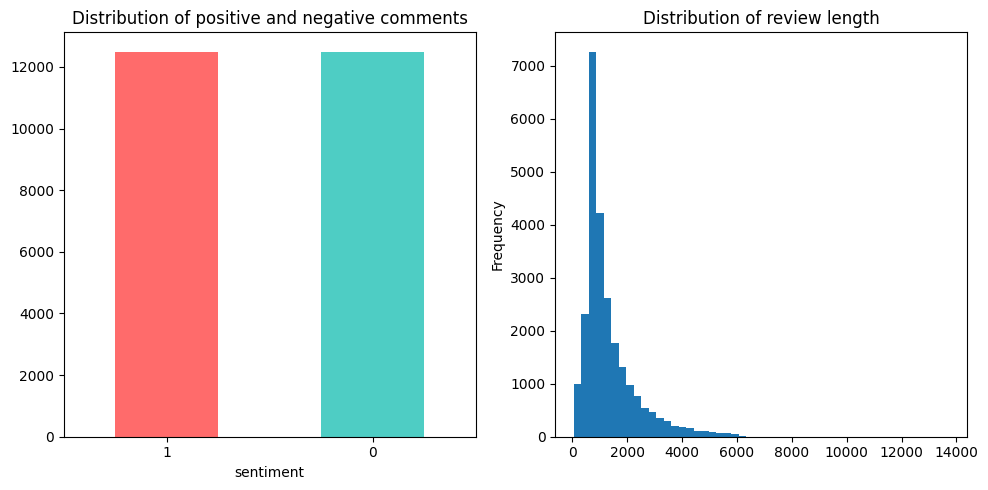


📝 训练集标签分布:
sentiment
1    12500
0    12500
Name: count, dtype: int64

📝 原始评论示例:
"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want  ...


In [18]:
#4.数据可视化 
# 设置中文字体为 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号


print("\n📈 正在生成数据可视化...")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# 正负面评论分布
train['sentiment'].value_counts().plot(
    kind='bar',
    color=['#FF6B6B', '#4ECDC4'],
    title='Distribution of positive and negative comments'
)
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
# 评论长度分布
train['review'].str.len().plot(
    kind='hist',
    bins=50,
    title='Distribution of review length'
)
plt.tight_layout()
plt.show()

print("\n📝 训练集标签分布:")
print(train['sentiment'].value_counts())
print("\n📝 原始评论示例:")
print(train['review'].iloc[0][:200], "...")



In [19]:
# 5. 文本预处理
print("\n🛠️ 开始文本预处理...")

class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'<[^>]+>', ' ', text)
        text = re.sub(r'http\S+', ' ', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', ' ', text)
        return ' '.join(text.split())
    
    def preprocess(self, text):
        cleaned = self.clean_text(text)
        tokens = [self.lemmatizer.lemmatize(w) for w in word_tokenize(cleaned) 
                 if w not in STOPWORDS and len(w) > 2]
        return ' '.join(tokens)

preprocessor = TextPreprocessor()

print("\n🔧 预处理示例:")
print("   原始文本:", train['review'].iloc[0][:100], "...")
print("   清洗后:", preprocessor.clean_text(train['review'].iloc[0])[:100], "...")
print("   最终处理:", preprocessor.preprocess(train['review'].iloc[0])[:100], "...")

print("\n⏳ 正在处理训练集...")
train['processed'] = train['review'].progress_apply(preprocessor.preprocess)
print("\n⏳ 正在处理测试集...")
test['processed'] = test['review'].progress_apply(preprocessor.preprocess)

print("\n✅ 预处理完成")
print("   处理后示例:", train['processed'].iloc[0][:100], "...")




🛠️ 开始文本预处理...

🔧 预处理示例:
   原始文本: "With all this stuff going down at the moment with MJ i've started listening to his music, watching  ...
   清洗后: with all this stuff going down at the moment with mj i ve started listening to his music watching th ...
   最终处理: stuff going moment started listening music watching odd documentary watched wiz watched moonwalker m ...

⏳ 正在处理训练集...


100%|██████████| 25000/25000 [00:33<00:00, 746.93it/s]



⏳ 正在处理测试集...


100%|██████████| 25000/25000 [00:32<00:00, 763.69it/s]


✅ 预处理完成
   处理后示例: stuff going moment started listening music watching odd documentary watched wiz watched moonwalker m ...


In [21]:
# 6. 模型训练
print("\n🤖 正在构建模型管道...")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=5,
        max_df=0.7
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    ))
])

print("\n🔧 模型配置:")
print("   - 特征数量: 10,000")
print("   - N-gram范围: (1, 2)")
print("   - 最小文档频率: 5")
print("   - 最大文档频率: 0.7")
print("   - 逻辑回归迭代次数: 1000")

print("\n⏳ 正在划分训练集/验证集...")
X_train, X_val, y_train, y_val = train_test_split(
    train['processed'], 
    train['sentiment'], 
    test_size=0.2, 
    random_state=42
)
print(f"   - 训练样本: {len(X_train)}")
print(f"   - 验证样本: {len(X_val)}")

print("\n⏳ 开始训练模型...")
pipeline.fit(X_train, y_train)
print("✅ 模型训练完成")




🤖 正在构建模型管道...

🔧 模型配置:
   - 特征数量: 10,000
   - N-gram范围: (1, 2)
   - 最小文档频率: 5
   - 最大文档频率: 0.7
   - 逻辑回归迭代次数: 1000

⏳ 正在划分训练集/验证集...
   - 训练样本: 20000
   - 验证样本: 5000

⏳ 开始训练模型...
✅ 模型训练完成


In [22]:
# 7. 模型评估
print("\n📊 正在评估模型...")
val_pred = pipeline.predict(X_val)
print("\n📝 验证集性能:")
print(f"   准确率: {accuracy_score(y_val, val_pred):.4f}")
print("\n📋 分类报告:")
print(classification_report(y_val, val_pred, target_names=['负面', '正面']))




📊 正在评估模型...

📝 验证集性能:
   准确率: 0.8906

📋 分类报告:
              precision    recall  f1-score   support

          负面       0.90      0.88      0.89      2481
          正面       0.88      0.90      0.89      2519

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [23]:
# 8. 生成预测
print("\n🔮 正在生成测试集预测...")
test_pred = pipeline.predict(test['processed'])
print(f"   预测完成，正面评论比例: {test_pred.mean():.2%}")




🔮 正在生成测试集预测...
   预测完成，正面评论比例: 50.28%


In [25]:
#9. 保存结果
print("\n💾 正在保存结果...")
submission = pd.DataFrame({
    'id': test['id'],
    'sentiment': test_pred
})
submission.to_csv("submission.csv", index=False)
print("✅ 结果已保存为 submission.csv")




💾 正在保存结果...
✅ 结果已保存为 submission.csv


In [26]:
# 10. 流程完成 
print("\n" + "="*60)
print("🎉 分析流程完成！")
print("="*60)


🎉 分析流程完成！
